# A Demo of ForcePhotZTF

This is a demo of how to use the code to get forced photometry light curve for ZTF18abucvbf. </br>
First, let's import some packages.<br>
Remember to add the path of ForcePhotZTF to your system. 

In [1]:
import os

import sys
sys.path.append('/Users/yuhanyao/Documents/')

In [2]:
from ForcePhotZTF.keypairs import get_keypairs
from ForcePhotZTF.force_lc import download_marshal_lightcurve, prepare_forced_phot, get_force_lightcurve
from ForcePhotZTF.refine_lc import get_recerence_jds, quicklook_lc
DEFAULT_AUTHs = get_keypairs()
DEFAULT_AUTH_fps = DEFAULT_AUTHs[3]

In [3]:
name = 'ZTF18abucvbf'
targetdir = os.getcwd() + '/' + name + '/'

## 1.  Download marshal lightcurve and get a sense of the lightcurve    

In [4]:
download_marshal_lightcurve(name, targetdir)

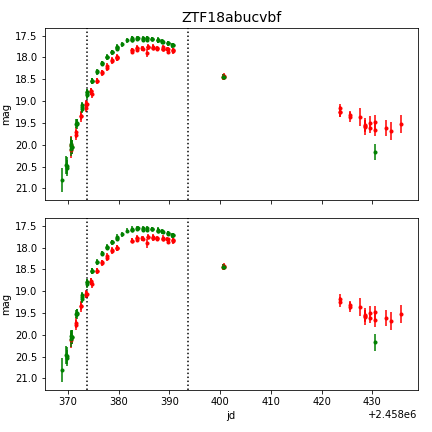

In [6]:
from IPython.core.display import Image 
Image(filename='./ZTF18abucvbf/marshal_lc_plot'+name+'.png',width=500)

This is the marshal light curve of this source (Patterson et al. 2019; Masci et al. 2019, ). r band obs in red; g band obs in green. Two dashed lines marks 10 days before and after the light curve brightest epoch. 

The upper panel shows all data points (including public data). The bottom panel shows all data points except for public data. MSIP data will be released on ~ May 1st, 2019. If most of your photometry are from the public program, running forced photometry may not be useful.

You may want to recenter the coordinate of this target (see Section 2.2) using observations around maximum luminosity. For this target, I would like to use all measurements brighter than 19.5 mag. That is, roughly speaking, 12 days before max light and 20 days after max light.

In [9]:
ndays_before_peak = 12
ndays_after_peak = 20
recenter_coo = True

## 2. Download images and recenter coordinate
The prepare_forced_phot will perform two tasks.
### 2.1 Download images
Download images from ipac (psfmodel image and difference image, ~5GB each target) using a corss-match radius of 36 arcsecs (0.01 deg, which is very conservative). 

### 2.2 Recenter Coordinate
Recenter coodinate based on observations around peak luminosity.

The coordinate given on the marshal website is based on the first detection, when the transient is relatively faint. Position can be estimated more accurately using images around peak luminosity. This code will get jd_peak from the marshal light curve. Then the recentered coordinate is estimated by taking the median of all target position within [jd_peak - ndays_before_peak, jd_peak + ndays_after_peak].

- If you want to use the marshal coordinate, just set recenter_coo = False
- Otherwise, set recenter_coo = True and specify ndays_before_peak \& ndays_after_peak.

In [10]:
prepare_forced_phot(name, targetdir = targetdir, recenter_coo = recenter_coo, 
                    ndays_before_peak = ndays_before_peak, 
                    ndays_after_peak = ndays_after_peak)



Start getting coordinate for ZTF18abucvbf
ZTF18abucvbf: ra=277.063748, dec=46.353408


Querying for metadata...
Trying to download 888 images from irsa...
In progress: 0 in 888
In progress: 50 in 888
In progress: 100 in 888
In progress: 150 in 888
In progress: 200 in 888
In progress: 250 in 888
In progress: 300 in 888
In progress: 350 in 888
In progress: 400 in 888
In progress: 450 in 888
In progress: 500 in 888
In progress: 550 in 888
In progress: 600 in 888
In progress: 650 in 888
In progress: 700 in 888
In progress: 750 in 888
In progress: 800 in 888
In progress: 850 in 888
168 images in 888 we do not have data:


Determining the coordinate based on observations around peak...
Reading: 0 in 720...
Reading: 100 in 720...
Reading: 200 in 720...
Reading: 300 in 720...
Reading: 400 in 720...
Reading: 500 in 720...
Reading: 600 in 720...
Reading: 700 in 720...
110 obs around peak to find the centroid
re-center: 0 in 110


/anaconda3/lib/python3.6/site-packages/image_registration/fft_tools/convolve_nd.py:269: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
/anaconda3/lib/python3.6/site-packages/image_registration/fft_tools/convolve_nd.py:270: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = kernel
/anaconda3/lib/python3.6/site-packages/image_registration/fft_tools/convolve_nd.py:325: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[se

re-center: 10 in 110
re-center: 20 in 110
re-center: 30 in 110
re-center: 40 in 110
re-center: 50 in 110
re-center: 60 in 110
re-center: 70 in 110
re-center: 80 in 110
re-center: 90 in 110
re-center: 100 in 110
remove 0 images with bad pixels
remove 0 images with seeing > 3 arcsec
remove 1 images with 3-sigma clipping


Let us take a look at how far is the re-centered coordinate from the marshal coordinate: 

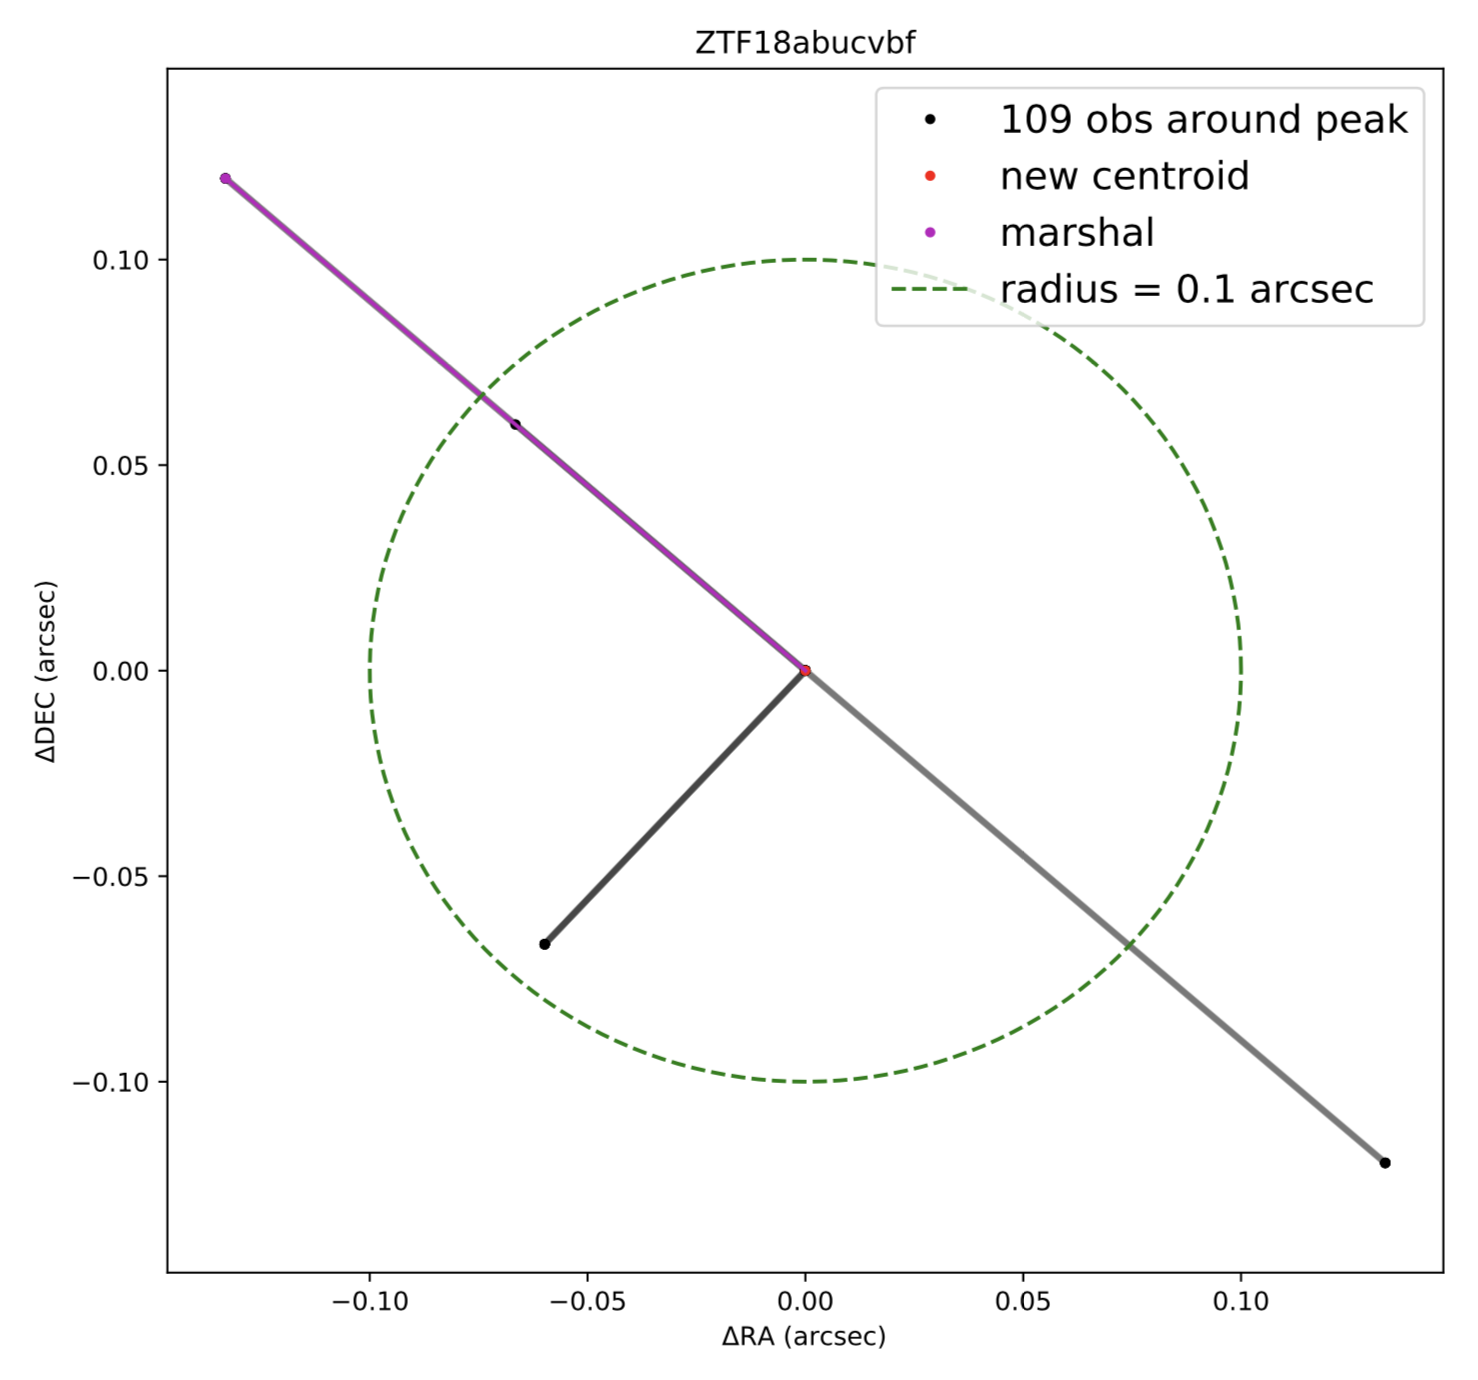

In [15]:
Image(filename='./ZTF18abucvbf/astrometry.png', width=500)

About 0.17 arcsec, which is very small (~0.17 ZTF pixel).

## 3. Perform PSF fitting

The default cutout size is a 7x7 pixel square, where 7 = 2 x r\_psf + 1. 
Background noise is estimated by taking an annulus with inner radius = 10 pixel, and outer radius = 15 pixel. You can adjust those parameters (although I do not recommend you to do so).
        
You can visually inspect the cutouts, the fitting, and the residual by setting the plot_mod parameter. For example, plot_mod = 20 will output a figure every 20 measurements. 

In [16]:
r_psf = 3
r_bkg_in = 10
r_bkg_out = 15
plot_mod = 20
get_force_lightcurve(name, targetdir, r_psf = r_psf, plot_mod = plot_mod,
                    r_bkg_in = r_bkg_in, r_bkg_out = r_bkg_out,
                    manual_mask = False, 
                    col_mask_start = 0, col_mask_end = 0,                  
                    row_mask_start = 0, row_mask_end = 0)



Start fitting forced light curve for ZTF18abucvbf...
In progress: 0 in 720...
Set status to False -- Bad pixel in the central 3x3 cutout!
Set status to False -- Bad pixel in the central 3x3 cutout!
Set status to False -- Bad pixel in the central 3x3 cutout!
In progress: 20 in 720...
Set status to False -- Bad pixel in the central 3x3 cutout!
Set status to False -- Bad pixel in the central 3x3 cutout!
Set status to False -- Bad pixel in the central 3x3 cutout!
12 bad pixels in 7*7 source frame


/Users/yuhanyao/Documents/ForcePhotZTF/phot_class.py:279: RuntimeWarning: invalid value encountered in less
  ind = (scr_fn/gain + bkgstd**2<0)


12 bad pixels in 7*7 source frame
In progress: 40 in 720...
Set status to False -- Bad pixel in the central 3x3 cutout!
In progress: 60 in 720...
In progress: 80 in 720...
In progress: 100 in 720...
Set status to False -- Bad pixel in the central 3x3 cutout!
Set status to False -- Bad pixel in the central 3x3 cutout!
In progress: 120 in 720...
In progress: 140 in 720...
In progress: 160 in 720...
In progress: 180 in 720...
In progress: 200 in 720...
In progress: 220 in 720...
In progress: 240 in 720...
In progress: 260 in 720...
In progress: 280 in 720...
In progress: 300 in 720...
In progress: 320 in 720...
In progress: 340 in 720...
In progress: 360 in 720...
In progress: 380 in 720...
In progress: 400 in 720...
In progress: 420 in 720...
In progress: 440 in 720...
In progress: 460 in 720...
In progress: 480 in 720...
In progress: 500 in 720...
In progress: 520 in 720...
In progress: 540 in 720...
In progress: 560 in 720...
In progress: 580 in 720...
In progress: 600 in 720...
In pro

Let us take a look at some of the fitting visualization.

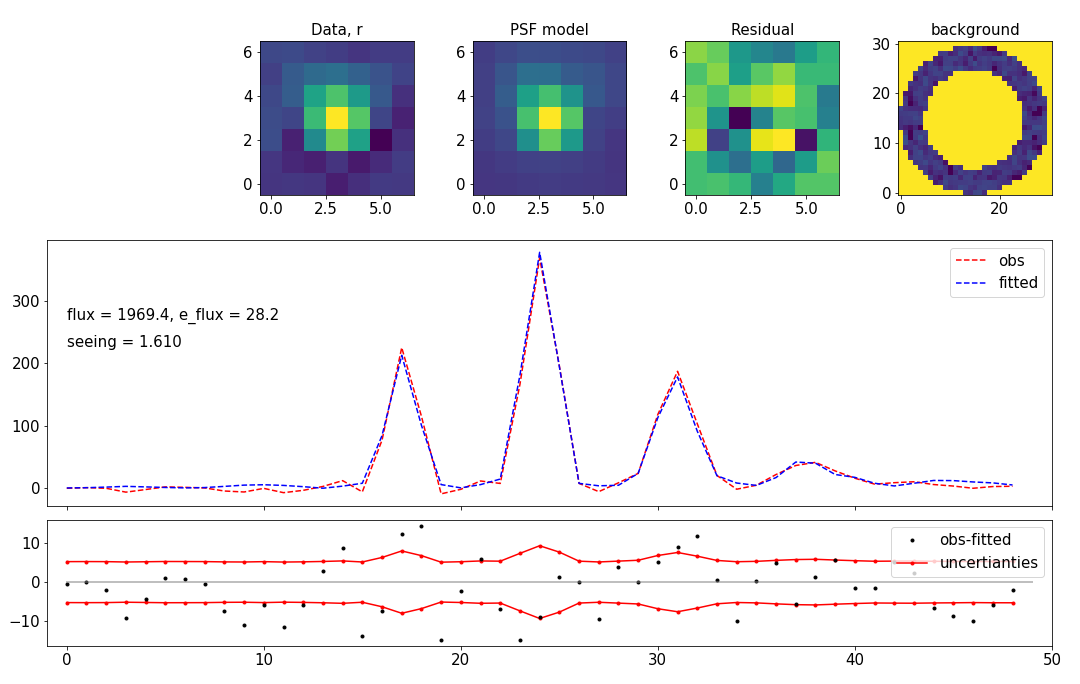

In [19]:
Image(filename='./ZTF18abucvbf/figures/580_ztf_20180917141875_000764_zr_c05_o_q3.png', width=700)

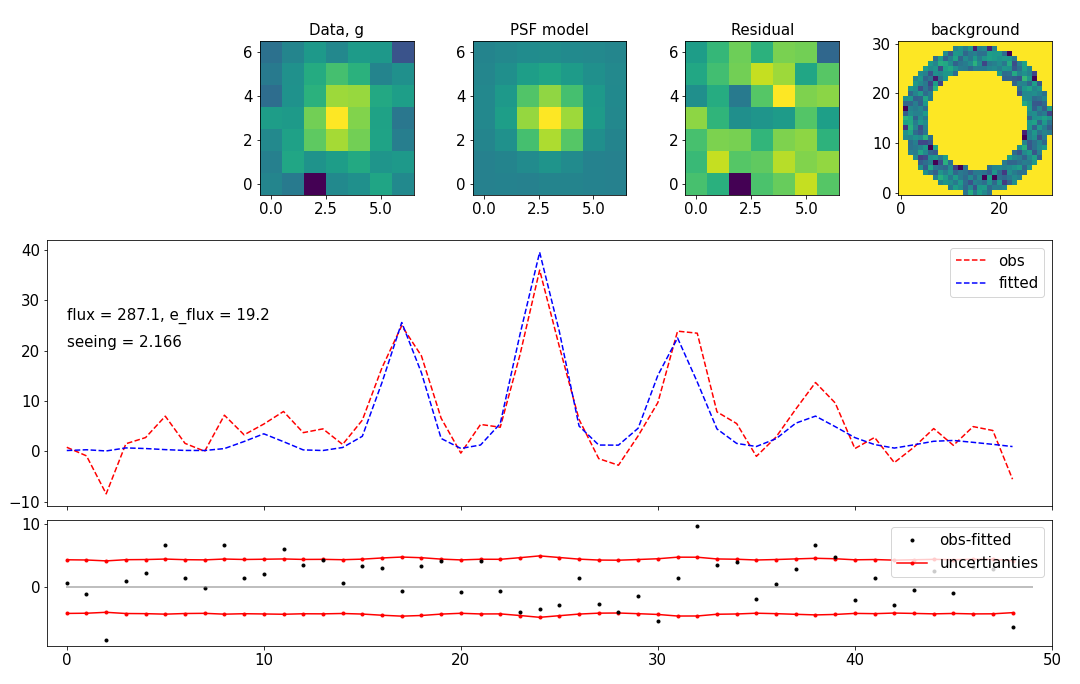

In [22]:
Image(filename='./ZTF18abucvbf/figures/540_ztf_20180909202245_000764_zg_c05_o_q3.png', width=700)

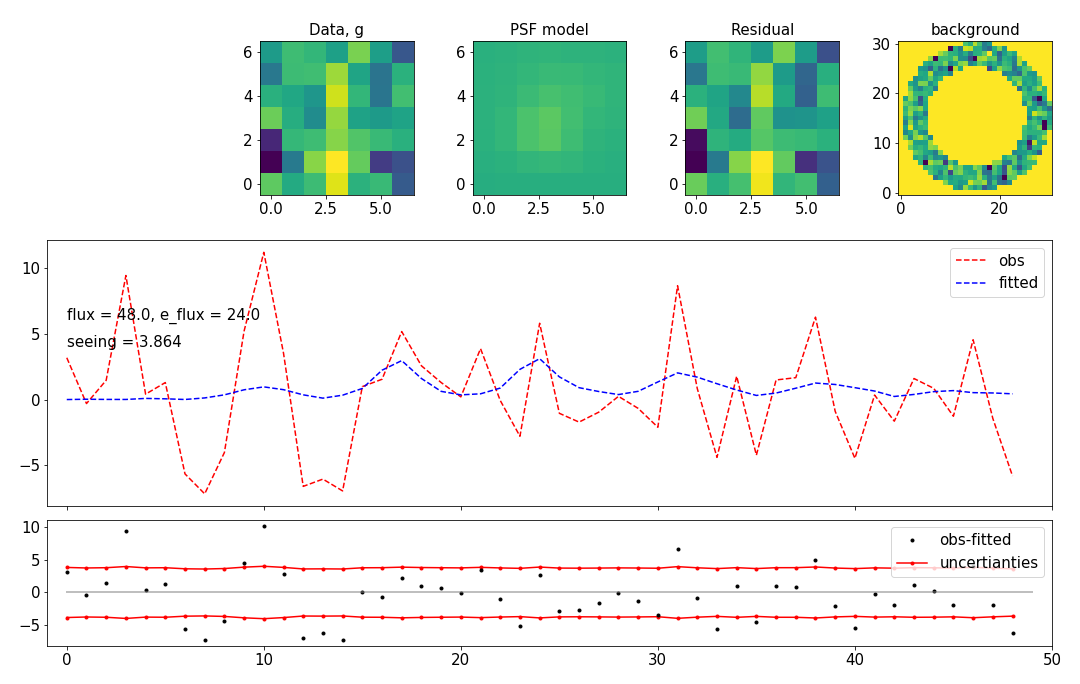

In [23]:
Image(filename='./ZTF18abucvbf/figures/100_ztf_20180523434988_000764_zg_c05_o_q3.png', width=700)

## 4. Getting the reference exposure epochs

In [24]:
get_recerence_jds(name, targetdir, partnership = False)

Start getting jd of reference exposures for ZTF18abucvbf
fieldid: 764, ccdid: 5, qid: 3, filterid: 1 
 	 startjd: 2458204.97, endjd: 2458230.91 

fieldid: 764, ccdid: 5, qid: 3, filterid: 2 
 	 startjd: 2458158.97, endjd: 2458227.01 



## 5. Take a quick look

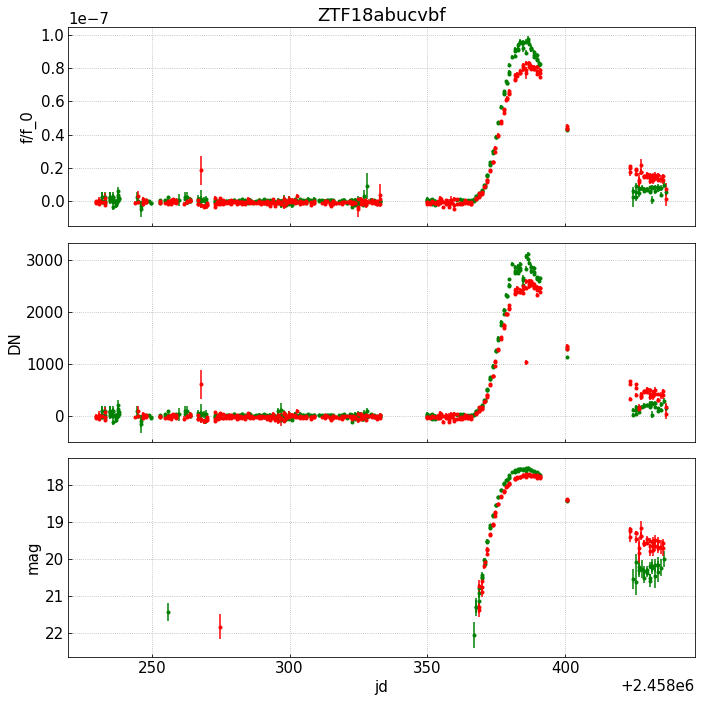

In [25]:
quicklook_lc(name, targetdir)

A beautiful light curve!

## 5. Quality Cuts
TBD

## 6. Baseline Correction and Uncertainty Validation

Please see Section 8 and 9 of \url{http://web.ipac.caltech.edu/staff/fmasci/ztf/forcedphot.pdf} for details.